<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-and-Tidy-Data" data-toc-modified-id="Load-and-Tidy-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Tidy Data</a></span></li><li><span><a href="#MULTIVARIATE-PREDICTION-(WITH-LOOKBACK-AND-TIMESTEPS)" data-toc-modified-id="MULTIVARIATE-PREDICTION-(WITH-LOOKBACK-AND-TIMESTEPS)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)</a></span></li><li><span><a href="#Building-the-Model" data-toc-modified-id="Building-the-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Building the Model</a></span></li><li><span><a href="#Set-ESN-constraints" data-toc-modified-id="Set-ESN-constraints-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Set ESN constraints</a></span></li><li><span><a href="#Loss-Functions" data-toc-modified-id="Loss-Functions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Loss Functions</a></span></li><li><span><a href="#Save-model-while-training" data-toc-modified-id="Save-model-while-training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Save model while training</a></span></li><li><span><a href="#Fitting-the-model" data-toc-modified-id="Fitting-the-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Fitting the model</a></span></li><li><span><a href="#RMSE-for-predictions" data-toc-modified-id="RMSE-for-predictions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>RMSE for predictions</a></span></li><li><span><a href="#Plot-prediction-and-actual-data-together" data-toc-modified-id="Plot-prediction-and-actual-data-together-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Plot prediction and actual data together</a></span></li></ul></div>

# Imports

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, SimpleRNN
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


# Load and Tidy Data

In [2]:
data = pd.read_csv(filepath_or_buffer="../Data/growth_rate.csv", index_col="date")

In [3]:
data.head()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
gr1,-0.005605,0.001242,-0.009662,0.007045,-0.012941,0.003184,0.004793,0.002356
gr2,-0.010147,-0.011166,0.005420,0.007103,-0.005543,0.001370,0.001068,0.003526
gr3,-0.026196,-0.022585,0.004313,0.024631,-0.037513,0.010516,0.019203,0.023925
gr4,0.005848,0.006418,-0.001610,-0.001314,0.001114,-0.002923,0.001535,0.013072
gr5,-0.004651,-0.003827,0.000000,0.007031,0.008009,0.003789,-0.000836,-0.007742


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7930 entries, gr1 to gr7930
Data columns (total 8 columns):
TCMNOM_Y10          7930 non-null float64
TCMNOM_Y2           7930 non-null float64
DCOILBRENTEU        7930 non-null float64
spindx              7930 non-null float64
GOLDPMGBD228NLBM    7930 non-null float64
exalus              7930 non-null float64
exjpus              7930 non-null float64
exukus              7930 non-null float64
dtypes: float64(8)
memory usage: 557.6+ KB


In [5]:
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7930 entries, gr1 to gr7930
Data columns (total 8 columns):
TCMNOM_Y10          7930 non-null float64
TCMNOM_Y2           7930 non-null float64
DCOILBRENTEU        7930 non-null float64
spindx              7930 non-null float64
GOLDPMGBD228NLBM    7930 non-null float64
exalus              7930 non-null float64
exjpus              7930 non-null float64
exukus              7930 non-null float64
dtypes: float64(8)
memory usage: 557.6+ KB


In [6]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
data.columns

Index(['TCMNOM_Y10', 'TCMNOM_Y2', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [9]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [10]:
look_back = 10 
time_steps = 10
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var1(t-9),var2(t-9),...,var7(t+8),var8(t+8),var1(t+9),var2(t+9),var3(t+9),var4(t+9),var5(t+9),var6(t+9),var7(t+9),var8(t+9)
7916,-0.000397,0.000000,-0.012945,0.008123,0.012906,0.003322,-0.002633,0.003779,0.000711,0.010638,...,-0.007908,0.000128,-0.006560,0.000000,0.000000,0.002067,-0.002472,0.001985,0.007524,0.001411
7917,0.000711,0.010638,0.032787,-0.002102,-0.002905,0.008567,0.004663,-0.000779,-0.008170,0.007018,...,0.007524,0.001411,0.015667,0.010676,0.012987,-0.024239,-0.004387,-0.005306,0.002400,0.006019
7918,-0.008170,0.007018,0.012698,0.007256,0.001873,0.008423,-0.003503,-0.001559,-0.005528,0.003484,...,0.002400,0.006019,0.010851,0.010563,0.009615,-0.011099,-0.008528,0.003058,0.000887,-0.003819
7919,-0.005528,0.003484,0.012539,-0.011038,0.000291,0.004247,-0.002021,-0.006637,-0.000395,0.000000,...,0.000887,-0.003819,0.010558,-0.010453,-0.003175,-0.047969,0.013334,-0.013755,-0.000620,-0.014952
7920,-0.000395,0.000000,-0.003096,-0.010573,-0.013997,-0.003101,-0.001893,-0.001441,-0.001418,0.000000,...,-0.000620,-0.014952,-0.006317,0.024648,0.025478,-0.001965,0.000772,-0.001366,0.002660,0.000649


In [11]:
scaled = reframed.values

In [12]:
# training and testing set
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [13]:
# split into input and outputs
train_X, train_y = train[:, :-8 * time_steps], train[:, -8 * time_steps:]
test_X, test_y = test[:, :-8 * time_steps], test[:, -8 * time_steps:]

In [14]:
train_X.shape

(5537, 80)

In [15]:
train_y.shape

(5537, 80)

In [16]:
train_X = train_X.reshape((train_X.shape[0], look_back, number_of_variables))
test_X = test_X.reshape((test_X.shape[0], look_back, number_of_variables))
train_y = train_y.reshape((train_y.shape[0], time_steps, number_of_variables))
test_y = test_y.reshape((test_y.shape[0], time_steps, number_of_variables))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5537, 10, 8) (5537, 10, 8) (2374, 10, 8) (2374, 10, 8)


# Building the Model

In [17]:
import random
random.seed(12345)

In [18]:
model = Sequential()
model.add(SimpleRNN(400, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, 
                    kernel_initializer='orthogonal', bias_initializer='zeros'))#, trainable= False))
model.add(SimpleRNN(400,return_sequences=True))
model.add(TimeDistributed(Dense(8, activation = 'linear')))

# Set ESN constraints

In [19]:
alpha = 0.5
w01, w02, w03 = model.layers[0].get_weights()
model.layers[0].set_weights([w01,alpha*w02,w03])

w11, w12, w13 = model.layers[1].get_weights()
model.layers[1].set_weights([w11,alpha*w12,w13])

# Loss Functions

In [20]:
import keras.backend as K

epsilon = 1.0e-9
def qlike_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.log(y_pred) + y_true / y_pred
    return K.mean(loss, axis=-1)

def mse_log(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.square(K.log(y_true) - K.log(y_pred))
    return K.mean(loss, axis=-1)

def mse_sd(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.square(y_true - K.sqrt(y_pred))
    return K.mean(loss, axis=-1)    

def hmse(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.square(y_true / y_pred - 1.)
    return K.mean(loss, axis=-1)    

def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred))
    return K.mean(loss, axis=-1)

def richy(y_true, y_pred):
    var_diff = K.var(y_true) - K.var(y_pred)
    abs_diff_ratio = K.mean(K.square(y_true/K.abs(y_true)- (y_pred/K.abs(y_pred))))
    return 0.5*var_diff + 0.5*abs_diff_ratio

def var_dir_loss(y_true, y_pred):
    var_diff = K.var(y_true)**2 - K.var(y_pred)**2
    abs_diff_ratio = K.mean(K.square(y_true/K.abs(y_true)- (y_pred/K.abs(y_pred))))
    return var_diff + abs_diff_ratio

# Linex Loss
def sign_ae(x, y):
    sign_x = K.sign(x)
    sign_y = K.sign(y)
    delta = x - y
    return sign_x * sign_y * K.abs(delta)
    
    
def linex_loss(delta, a=-1, b=1):
    if a!= 0 and b > 0:
        loss = b * (K.exp(a * delta) - a * delta - 1)
        return loss
    else:
        raise ValueError
        
# for growth rate      
def linex_loss_val(y_true, y_pred): 
    delta = sign_ae(y_true, y_pred)
    res = linex_loss(delta)
    return K.mean(res)
    
# for levels  
def linex_loss_ret(y_true, y_pred):
    diff_true = y_true[1:] - y_true[:-1]
    diff_pred = y_pred[1:] - y_pred[:-1]
    
    delta = sign_ae(diff_true, diff_pred)
    res = linex_loss(delta)
    return K.mean(res)

# Save model while training

In [21]:
from keras.callbacks import ModelCheckpoint

weight_path="{}.hdf5".format('ESN_growthrate_adam')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]

In [22]:
model.compile(optimizer='sgd', loss=linex_loss_val)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10, 400)           163600    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10, 400)           320400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 8)             3208      
Total params: 487,208
Trainable params: 487,208
Non-trainable params: 0
_________________________________________________________________


# Fitting the model

In [23]:
n_batch = 256
history = model.fit(train_X, train_y, epochs=100, batch_size=n_batch, validation_data=(test_X, test_y), callbacks = callbacks_list)

Train on 5537 samples, validate on 2374 samples
Epoch 1/100
5537/5537 [==============================] - 2s 386us/step - loss: 1.0566e-04 - val_loss: 2.5087e-04

Epoch 00001: val_loss improved from inf to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 2/100
5537/5537 [==============================] - 2s 343us/step - loss: 1.0565e-04 - val_loss: 2.5086e-04

Epoch 00002: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 3/100
5537/5537 [==============================] - 2s 329us/step - loss: 1.0565e-04 - val_loss: 2.5086e-04

Epoch 00003: val_loss did not improve from 0.00025
Epoch 4/100
5537/5537 [==============================] - 2s 318us/step - loss: 1.0564e-04 - val_loss: 2.5086e-04

Epoch 00004: val_loss did not improve from 0.00025
Epoch 5/100
5537/5537 [==============================] - 2s 351us/step - loss: 1.0564e-04 - val_loss: 2.5085e-04

Epoch 00005: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_ada

5537/5537 [==============================] - 2s 395us/step - loss: 1.0561e-04 - val_loss: 2.5078e-04

Epoch 00042: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 43/100
5537/5537 [==============================] - 2s 394us/step - loss: 1.0561e-04 - val_loss: 2.5078e-04

Epoch 00043: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 44/100
5537/5537 [==============================] - 2s 416us/step - loss: 1.0561e-04 - val_loss: 2.5078e-04

Epoch 00044: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 45/100
5537/5537 [==============================] - 2s 383us/step - loss: 1.0561e-04 - val_loss: 2.5078e-04

Epoch 00045: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 46/100
5537/5537 [==============================] - 2s 419us/step - loss: 1.0561e-04 - val_loss: 2.5078e-04

Epoch 00046: val_loss improved from 0.00025 to 0.0

5537/5537 [==============================] - 2s 356us/step - loss: 1.0558e-04 - val_loss: 2.5069e-04

Epoch 00082: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 83/100
5537/5537 [==============================] - 2s 358us/step - loss: 1.0558e-04 - val_loss: 2.5069e-04

Epoch 00083: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 84/100
5537/5537 [==============================] - 2s 353us/step - loss: 1.0558e-04 - val_loss: 2.5068e-04

Epoch 00084: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 85/100
5537/5537 [==============================] - 2s 394us/step - loss: 1.0558e-04 - val_loss: 2.5068e-04

Epoch 00085: val_loss improved from 0.00025 to 0.00025, saving model to ESN_growthrate_adam.hdf5
Epoch 86/100
5537/5537 [==============================] - 2s 364us/step - loss: 1.0558e-04 - val_loss: 2.5068e-04

Epoch 00086: val_loss did not improve from 0.00025

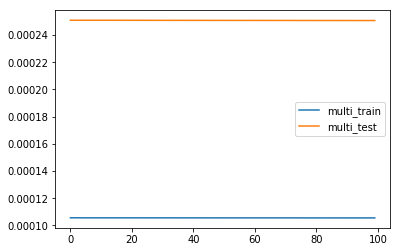

In [24]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [25]:
test_X.shape

(2374, 10, 8)

In [26]:
yhat = model.predict(test_X)

In [27]:
test_y.shape

(2374, 10, 8)

In [28]:
yhat.shape

(2374, 10, 8)

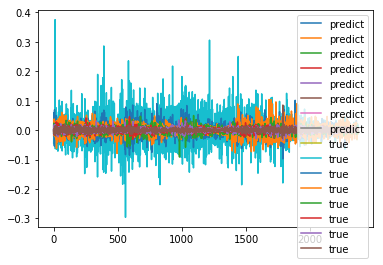

In [29]:
pyplot.plot(yhat[:,0], label='predict')
pyplot.plot(test_y[:,0], label='true')
pyplot.legend()
pyplot.show()

# RMSE for predictions

In [30]:
rmse = sqrt(mean_squared_error(yhat[:,4], test_y[:,4]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.022


In [31]:
predictDates = data.tail(len(test_y)).index
actual_chart = go.Scatter(x=predictDates, y=test_y[:,0][:,0], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=yhat[:,0][:,0], name= 'Multi Predict Price')
py.iplot([multi_predict_chart])

# Plot prediction and actual data together

In [32]:
py.iplot([multi_predict_chart, actual_chart])